In [54]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [55]:
def relu(x):
    return jnp.maximum(0.0, x)

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))



In [56]:
in_dim = 1
out_dim = 1
hidden_dims = [2]          
num_layers = len(hidden_dims) + 1

weights = []
biases = []

class NeuralNetwork:
    def __init__(self, in_dim, out_dim, hidden_dims, key):
        self.layer_dims = [in_dim] + hidden_dims + [out_dim]
        self.num_layers = len(self.layer_dims) - 1
        self.params = self.init_params(key)

    def init_params(self, key):
        params = []
        keys = jax.random.split(key, self.num_layers)

        for i in range(self.num_layers):
            k = keys[i]
            W = jax.random.normal(k, (self.layer_dims[i], self.layer_dims[i + 1]))
            b = jnp.zeros((self.layer_dims[i + 1],))
            params.append((W, b))

        return params

def forward(params, x, activation):
    h = x
    for i, (W, b) in enumerate(params):
        z = h @ W + b
        if i < len(params) - 1:
            h = activation(z)
        else:
            h = z
    return h


In [57]:
def mse_loss(params,  x, y_true, activation):
    y_pred = forward(params, x, activation)
    return jnp.mean((y_pred - y_true) ** 2)

In [58]:
from functools import partial

@partial(jax.jit,  static_argnames=("activation",))

def train_step(params, x, y, lr, activation):
    loss, grads = jax.value_and_grad(mse_loss)(params, x, y, activation)

    new_params = [
        (W - lr * dW, b - lr * db)
        for (W, b), (dW, db) in zip(params, grads)
    ]

    return new_params, loss

# Exercise 3

Generating the data and splitting it into 80/20 train/test datasets, where we shuffle to avoid the model from learning orders. 

In [59]:
import numpy as np


# generate training data

def training_data(k,N):
    x = jnp.linspace(-1.0, 1.0, N).reshape(-1, 1)
    y = jnp.sin(k * jnp.pi * x)
    return x,y


def train_test_split(x, y, key, test_ratio=0.2):
    N = x.shape[0]
    key, subkey = jax.random.split(key)
    perm = jax.random.permutation(subkey, N)

    x_shuffled = x[perm]
    y_shuffled = y[perm]

    test_size = int(test_ratio * N)

    x_test = x_shuffled[:test_size]
    y_test = y_shuffled[:test_size]

    x_train = x_shuffled[test_size:]
    y_train = y_shuffled[test_size:]

    return x_train, y_train, x_test, y_test




Neural network training function flexible for changing hyperparameters

In [67]:
def train_nn(key, hidden_dims, activation, lr, batch_size, x_train, y_train, num_epochs):
    key, subkey = jax.random.split(key)
    model = NeuralNetwork(
        in_dim = 1,
        out_dim = 1,
        hidden_dims = hidden_dims, 
        key = subkey
    )

    params = model.params

    num_samples = x_train.shape[0]
    num_batches = num_samples // batch_size

    epoch_losses = []
    
    for epoch in range(num_epochs):
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, num_samples)

        x_shuffled = x_train[perm]
        y_shuffled = y_train[perm]

        total_loss = 0
        for i in range(0, num_samples, batch_size):
            xb = x_shuffled[i: i + batch_size]
            yb = y_shuffled[i: i + batch_size]
                
            params, loss = train_step(
                params, 
                xb, 
                yb, 
                lr, 
                activation
            )
            total_loss += loss
        epoch_mse = mse_loss(params, x_train, y_train, activation)
        epoch_losses.append(epoch_mse)

    return params, epoch_losses

The cross validation function

In [61]:
def make_folds(key, N, n_folds=5):
    
    perm = jax.random.permutation(key, N)
    return jnp.array_split(perm, n_folds)

def cross_val_score(key, hidden_dims, activation, lr, batch_size, x_train, y_train, num_epochs, n_folds = 5):

    N = x_train.shape[0]
    folds = make_folds(key, N, n_folds)
    val_losses = []

    for i in range(n_folds):
        val_idx = folds[i]
        train_idx = jnp.concatenate(
            [folds[j] for j in range(n_folds) if j != i]
        )

        x_train = x_train[train_idx]
        y_train = y_train[train_idx]
        x_val = x_train[val_idx]
        y_val = y_train[val_idx]

        key, subkey = jax.random.split(key)

        params, loss = train_nn(
            key=subkey,
            hidden_dims=hidden_dims,
            activation=activation,
            lr=lr,
            batch_size=batch_size,
            x_train=x_train,
            y_train=y_train,
            num_epochs=num_epochs
        )

        val_loss = mse_loss(params, x_val, y_val, activation)
        val_losses.append(val_loss)
    return jnp.mean(jnp.array(val_losses))

    

Grid search function and defining parameter grid such as in exercise 2

In [65]:
# grid search for hyperparameter optimization for fitting f1
# Hyperparameters to vary (Question 2a)

param_grid = {
    'architectures': [[128], [128, 64]],
    'learning_rates': [0.1, 0.01],
    'batch_sizes': [32],
    'activations': [relu, sigmoid],
    'init_type': ["xavier"]
}
    

def grid_search_cv(
    param_grid,
    key,
    x,
    y,
    num_epochs,
    n_folds=5
):
    best_loss = jnp.inf
    best_config = None

    keys = jax.random.split(
        key,
        len(param_grid['learning_rates'])
        * len(param_grid['architectures'])
        * len(param_grid['batch_sizes'])
        * len(param_grid['activations'])
        * len(param_grid['epochs'])
    )

    idx = 0

    for lr in param_grid['learning_rates']:
        for arch in param_grid['architectures']:
            for batch_size in param_grid['batch_sizes']:
                for activation in param_grid['activations']:
                    for epoch in param_grid['epochs']:
                        subkey = keys[idx]
                        idx += 1

                        cv_loss = cross_val_score(
                            key=subkey,
                            hidden_dims=arch,
                            activation=activation,
                            lr=lr,
                            batch_size=batch_size,
                            x_train=x,
                            y_train=y,
                            num_epochs=epoch,
                            n_folds=n_folds
                        )

                        print(
                            f"lr={lr}, "
                            f"arch={arch}, "
                            f"batch_size={batch_size}, "
                            f"activation={activation.__name__}, "
                            f"epochs={epoch}, "
                            f"CV MSE={cv_loss:.6f}"
                        )

                        if cv_loss < best_loss:
                            best_loss = cv_loss
                            best_config = {
                                'learning_rate': lr,
                                'architecture': arch,
                                'batch_size': batch_size,
                                'activation': activation, 
                                'num_epochs': epoch
                            }

    return best_config, best_loss




    


Generating training data, finding best configuration and making predictions, finding MSE and plotting results functions for easy handling of different k values.




In [64]:
# generate training data varying k 
def generate_data_k(k, N, key):
    xk, yk = training_data(k, N)
    key, subkey = jax.random.split(key)
    xk_train, yk_train, xk_test, yk_test = train_test_split(xk, yk, key=subkey)
    return xk_train, yk_train, xk_test, yk_test


param_grid = {
    'architectures': [[128], [128, 64]],
    'learning_rates': [0.01, 0.001],
    'batch_sizes': [32],
    'activations': [relu, sigmoid],
    'init_type': ["xavier"],
    'epochs' : [2000, 4000]
}

def find_best_config(param_grid, xk_train, yk_train, key):
    # find best configuration 

    best_config, best_loss = grid_search_cv(
        param_grid=param_grid,
        key=key,
        x=xk_train,
        y=yk_train,
        num_epochs=1,
        n_folds=3
    )

    print("\nBest hyperparameters:")
    print(best_config)
    print("Best CV MSE:", best_loss)
    return best_config, best_loss

def predict_and_plot_test(best_config, xk_train, yk_train, xk_test, yk_test, key):
    key, subkey = jax.random.split(key)
    params, best_epoch_losses = train_nn(subkey, best_config['architecture'],best_config['activation'], best_config['learning_rate'], best_config['batch_size'], xk_train, yk_train, num_epochs=2000)

  
    yk_pred = forward(
        params,
        xk_test,
        best_config['activation']
    )
   
    print(jnp.max(yk_pred) - jnp.min(yk_pred))

    test_mse = jnp.mean((yk_pred - yk_test) ** 2)
    print("Test MSE:", test_mse)
    
    
    
    # sort test points for a clean plot
    idx = jnp.argsort(xk_test[:, 0])
    x_sorted = xk_test[idx]
    y_true_sorted = yk_test[idx]
    y_pred_sorted = yk_pred[idx]
    
    plt.figure()
    plt.plot(x_sorted, y_true_sorted, label="True function", linewidth=2)
    plt.plot(x_sorted, y_pred_sorted, "--", label="Model prediction", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Model prediction vs true function")
    plt.legend()
    plt.grid(True)
    plt.show()
    return test_mse



# Exercise 3a)

It can be seen that when varying the same hyperparameters as in question 2 the optimal configuration has learning rate 0.1, two hidden layers of 128 and 64 width, batch_size of 32 and the sigmoid activation function. However, it should be noted that all MSEs are very close to zero and although the configurations differ in the order of 100 in MSE, all models are suited to predict $f$ for $k=1$.

It is also interesting to note that the configuration with $[128, 64]$ architecture, activation function ReLu and learning rate 0.01 outputs as MSE NaN. Since the data is generated and not likely to cause errors, it suggests a numerical error in the training stage. When decreasing the learning rate to 0.001, this error does not occur. Therefore, it is likely due to very large parameter updates, leading to large values and potentially to 'gradient explosions'. This explanation also corresponds with finding this phenomenon happening for a 'deep' architecture, where gradients multiply across layers through the chain rule.

lr=0.01, arch=[128], batch_size=32, activation=relu, CV MSE=0.000052
lr=0.01, arch=[128], batch_size=32, activation=sigmoid, CV MSE=0.000099
lr=0.01, arch=[128, 64], batch_size=32, activation=relu, CV MSE=nan
lr=0.01, arch=[128, 64], batch_size=32, activation=sigmoid, CV MSE=0.000047
lr=0.001, arch=[128], batch_size=32, activation=relu, CV MSE=0.001843
lr=0.001, arch=[128], batch_size=32, activation=sigmoid, CV MSE=0.064544
lr=0.001, arch=[128, 64], batch_size=32, activation=relu, CV MSE=0.000086
lr=0.001, arch=[128, 64], batch_size=32, activation=sigmoid, CV MSE=0.002268

Best hyperparameters:
{'learning_rate': 0.01, 'architecture': [128, 64], 'batch_size': 32, 'activation': <function sigmoid at 0x000002C9AC6AE0E0>}
Best CV MSE: 4.7279504e-05
[(Array([[ 0.94245523,  0.08031665,  0.4216311 ,  0.5250364 , -0.6152717 ,
        -0.6810298 , -1.7048067 , -0.21609913, -0.17408137, -1.1290005 ,
        -0.18700184,  0.82533664,  0.48613423,  0.6462083 , -1.1770022 ,
         0.21289831,  0.7

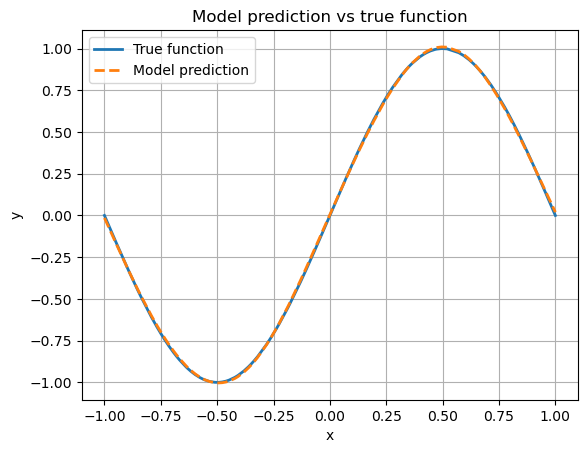

In [ ]:


key = jax.random.PRNGKey(0)

x1_train, y1_train, x1_test, y1_test = generate_data_k(1, 1000, key)
best_config_1, best_loss_1 =  find_best_config(param_grid, x1_train, y1_train, key)
test_mse_1 = predict_and_plot_test(best_config_1, x1_train, y1_train, x1_test, y1_test, key)

# Exercise 3b

when increasing k, it appears the model can not fit the increasingly nonlinear behaviour of the function $f(x)$ during the training when using the configuration as in 3a. This suggests increasing the amount of epochs, to give the model more time to converge, or increasing the width and depth of the model, such that it can fit more complex nonlinear behaviour. 

2.0105524
Test MSE: 0.0057946444


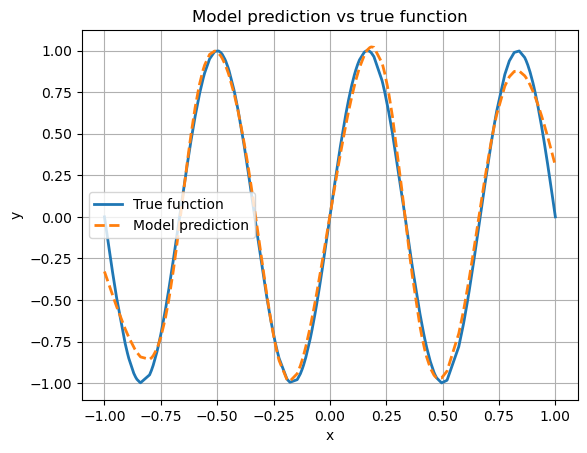

1.7972293
Test MSE: 0.38619697


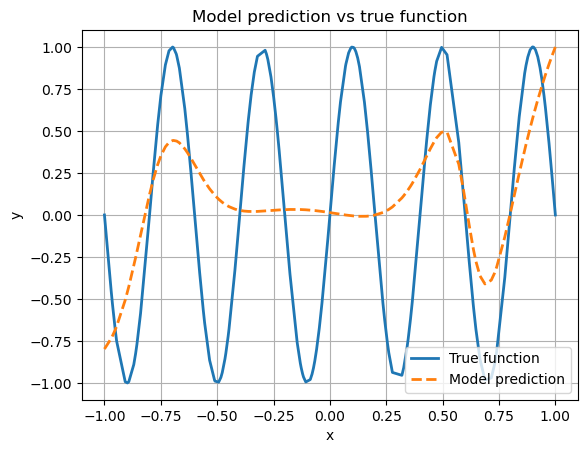

0.73953557
Test MSE: 0.5117685


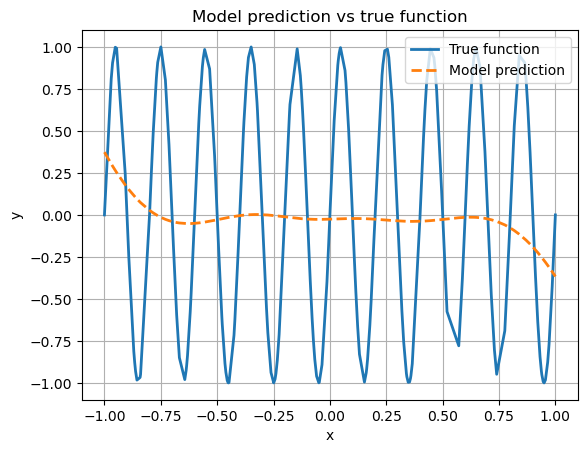

In [ ]:
def generate_train_test(key, k, param_grid):       
    xk_train, yk_train, xk_test, yk_test = generate_data_k(k, 1000, key)
    best_config_k, best_loss_k =  find_best_config(param_grid, xk_train, yk_train, key)
    test_mse_k = predict_and_plot_test(best_config_1, xk_train, yk_train, xk_test, yk_test, key) # test for best configuration found for k = 1 

generate_train_test(key, 3, param_grid)
generate_train_test(key, 5, param_grid)
generate_train_test(key, 10, param_grid)



To decrease the MSE for larger k, we tuned the following hyperparameters further: Network architecture, batch_size, learning rate, epochs. A deeper and wider neural network architecture allows to learn more complex functions. Increasing the batch size increases the batch gradient alignment to full batch gradient,  resulting in faster convergence. Learning rate needs to be tuned carefully to ensure stable training. 

We see that larger architectures do seem to help to fit to the complex data. In theory, a sufficiently large neural network can approximate any continuous function arbitrarily well on a compact interval. However, this comes at a price. As the function oscillates faster, the model must have more linear regions to approximate the data well. Therefore, we increase depth and width. This, however, implies higher computational cost as the number of matrix multiplications increase. 

Furthermore, achieving stable training and not overfitting to the data is a time consuming task the way we do it with grid search and constant variables. Using adaptive learning rate techniques, clipping gradients or other advanced techniques might streamline this process.

lr=0.001, arch=[128, 128], batch_size=64, activation=relu, epochs=4000, CV MSE=nan
lr=0.001, arch=[128, 128], batch_size=64, activation=sigmoid, epochs=4000, CV MSE=0.569310
lr=0.001, arch=[128, 128], batch_size=128, activation=relu, epochs=4000, CV MSE=nan
lr=0.001, arch=[128, 128], batch_size=128, activation=sigmoid, epochs=4000, CV MSE=0.387034
lr=0.001, arch=[128, 128], batch_size=256, activation=relu, epochs=4000, CV MSE=nan
lr=0.001, arch=[128, 128], batch_size=256, activation=sigmoid, epochs=4000, CV MSE=0.423828
lr=0.001, arch=[64, 64, 64], batch_size=64, activation=relu, epochs=4000, CV MSE=nan
lr=0.001, arch=[64, 64, 64], batch_size=64, activation=sigmoid, epochs=4000, CV MSE=0.258648
lr=0.001, arch=[64, 64, 64], batch_size=128, activation=relu, epochs=4000, CV MSE=nan
lr=0.001, arch=[64, 64, 64], batch_size=128, activation=sigmoid, epochs=4000, CV MSE=0.409281
lr=0.001, arch=[64, 64, 64], batch_size=256, activation=relu, epochs=4000, CV MSE=nan
lr=0.001, arch=[64, 64, 64], b

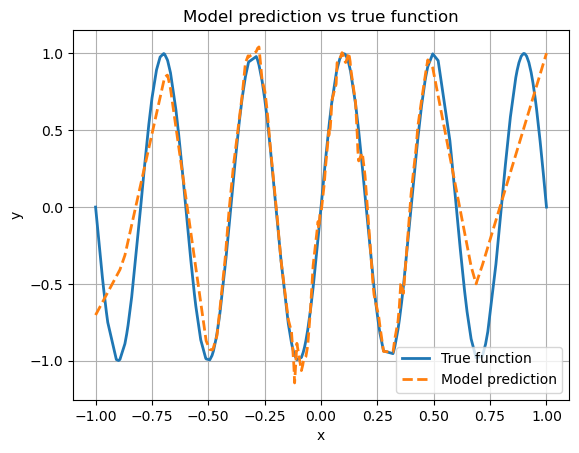

In [ ]:

param_grid_b = {
    'architectures': [[128, 128], [64, 64, 64]],
    'learning_rates': [0.001,0.0001],
    'batch_sizes': [64, 128, 256],
    'activations': [relu, sigmoid],
    'init_type': ["xavier"],
    'epochs' : [4000]
}

def generate_train_test(key, k, param_grid):       
    xk_train, yk_train, xk_test, yk_test = generate_data_k(k, 1000, key)
    best_config_k, best_loss_k =  find_best_config(param_grid, xk_train, yk_train, key)
    test_mse_k = predict_and_plot_test(best_config_k, xk_train, yk_train, xk_test, yk_test, key) 
    
generate_train_test(key, 5, param_grid_b)



lr=0.0001, arch=[128, 64], batch_size=32, activation=relu, epochs=2000, CV MSE=0.146880
lr=0.0001, arch=[128, 64], batch_size=32, activation=relu, epochs=5000, CV MSE=0.177607
lr=0.0001, arch=[128, 64], batch_size=32, activation=<lambda>, epochs=2000, CV MSE=0.210800
lr=0.0001, arch=[128, 64], batch_size=32, activation=<lambda>, epochs=5000, CV MSE=0.317159
lr=0.0001, arch=[128, 64], batch_size=64, activation=relu, epochs=2000, CV MSE=0.156222
lr=0.0001, arch=[128, 64], batch_size=64, activation=relu, epochs=5000, CV MSE=0.193090
lr=0.0001, arch=[128, 64], batch_size=64, activation=<lambda>, epochs=2000, CV MSE=0.173867
lr=0.0001, arch=[128, 64], batch_size=64, activation=<lambda>, epochs=5000, CV MSE=0.265768
lr=0.0001, arch=[128, 64], batch_size=128, activation=relu, epochs=2000, CV MSE=0.287041
lr=0.0001, arch=[128, 64], batch_size=128, activation=relu, epochs=5000, CV MSE=0.145062
lr=0.0001, arch=[128, 64], batch_size=128, activation=<lambda>, epochs=2000, CV MSE=0.182202
lr=0.0001

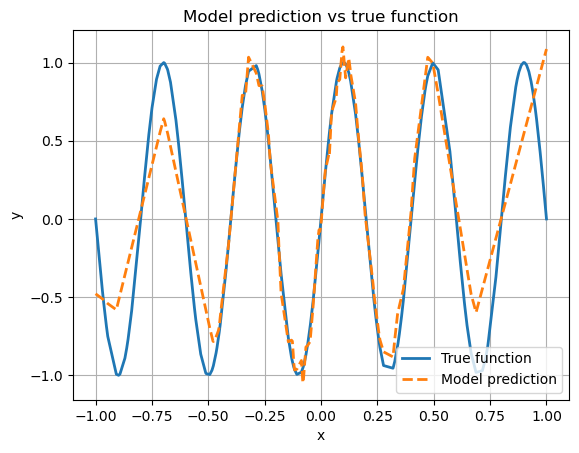

In [78]:
leaky_relu = lambda x: jnp.maximum(0.01 * x, x)  # Leaky ReLU

param_grid_b2 = {
    'architectures': [[128, 64], [64, 64, 64]],
    'learning_rates': [0.0001, 0.00001],
    'batch_sizes': [32, 64, 128],
    'activations': [relu, leaky_relu],
    'init_type': ["xavier"],
    'epochs' : [2000, 5000]
}

def generate_train_test(key, k, param_grid):       
    xk_train, yk_train, xk_test, yk_test = generate_data_k(k, 1000, key)
    best_config_k, best_loss_k =  find_best_config(param_grid, xk_train, yk_train, key)
    test_mse_k = predict_and_plot_test(best_config_k, xk_train, yk_train, xk_test, yk_test, key) 
    
generate_train_test(key, 5, param_grid_b2)

It seems that $[64,64,64]$-ReLu works best when not returning NaNs, therefore we finetune the hyperparameter for the most promising configurations. And we test the most promising configuration for $k=10$.

lr=0.0001, arch=[64, 64, 64], batch_size=32, activation=relu, epochs=2000, CV MSE=nan
lr=0.0001, arch=[64, 64, 64], batch_size=32, activation=relu, epochs=5000, CV MSE=nan
lr=0.0001, arch=[64, 64, 64], batch_size=32, activation=relu, epochs=7000, CV MSE=0.010651
lr=0.0001, arch=[64, 64, 64], batch_size=64, activation=relu, epochs=2000, CV MSE=nan
lr=0.0001, arch=[64, 64, 64], batch_size=64, activation=relu, epochs=5000, CV MSE=0.008392
lr=0.0001, arch=[64, 64, 64], batch_size=64, activation=relu, epochs=7000, CV MSE=nan
lr=1e-05, arch=[64, 64, 64], batch_size=32, activation=relu, epochs=2000, CV MSE=0.145348
lr=1e-05, arch=[64, 64, 64], batch_size=32, activation=relu, epochs=5000, CV MSE=0.606211
lr=1e-05, arch=[64, 64, 64], batch_size=32, activation=relu, epochs=7000, CV MSE=0.142127
lr=1e-05, arch=[64, 64, 64], batch_size=64, activation=relu, epochs=2000, CV MSE=0.177249
lr=1e-05, arch=[64, 64, 64], batch_size=64, activation=relu, epochs=5000, CV MSE=0.207759
lr=1e-05, arch=[64, 64, 

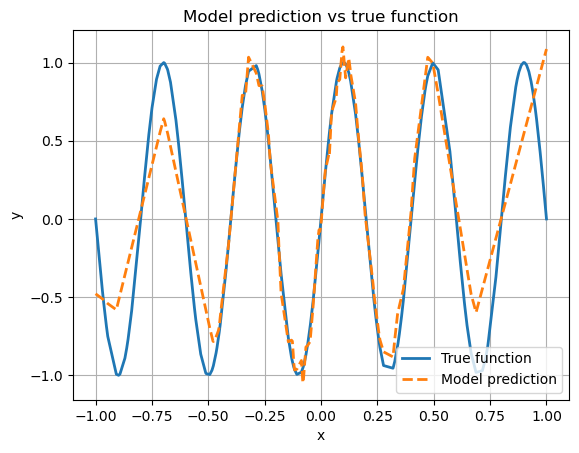

2.0885568
Test MSE: 0.19645332


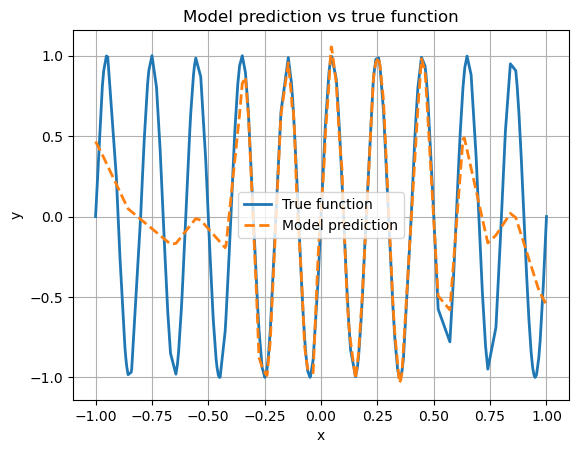

In [83]:
param_grid_b3 = {
    'architectures': [[64, 64, 64]],
    'learning_rates': [0.0001, 0.00001],
    'batch_sizes': [32, 64],
    'activations': [relu],
    'init_type': ["xavier"],
    'epochs' : [2000, 5000, 7000]
}


def generate_train_test(key, k, param_grid):       
    xk_train, yk_train, xk_test, yk_test = generate_data_k(k, 1000, key)
    best_config_k, best_loss_k =  find_best_config(param_grid, xk_train, yk_train, key)
    test_mse_k = predict_and_plot_test(best_config_k, xk_train, yk_train, xk_test, yk_test, key) 
    return best_config_k
    
best_config_5 = generate_train_test(key, 5, param_grid_b3)

x10_train, y10_train, x10_test, y10_test = generate_data_k(10, 1000, key)
test_mse_10 = predict_and_plot_test(best_config_5, x10_train, y10_train, x10_test, y10_test, key) 




